In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%run utils.py

## Generate maps

In [12]:
%%time

image_size = 28
frame_duration = 1.0
overlap = 0
X, y = make_data_pipeline(file_names, labels, image_size, frame_duration, overlap)
X.shape, y.shape

Generating training data...
CPU times: user 28.2 s, sys: 4.93 s, total: 33.1 sing 1/112Interpolating 65/112Interpolating 1/111Interpolating 47/111Interpolating 84/111Interpolating 1/109Interpolating 71/109Interpolating 1/113Interpolating 71/113Interpolating 1/104Interpolating 60/104Interpolating 1/101Interpolating 88/101Interpolating 1/102Interpolating 79/102Interpolating 1/107Interpolating 78/107Interpolating 1/113Interpolating 70/113Interpolating 1/115Interpolating 58/115Interpolating 1/139Interpolating 50/139Interpolating 113/139Interpolating 1/123Interpolating 61/123Interpolating 90/123Interpolating 1/118Interpolating 24/118Interpolating 58/118Interpolating 78/118Interpolating 108/118Interpolating 1/120Interpolating 27/120Interpolating 52/120Interpolating 79/120Interpolating 105/120Interpolating 1/117Interpolating 12/117Interpolating 29/117Interpolating 47/117Interpolating 63/117Interpolating 75/117Interpolating 103/117
Wall time: 26.2 s


((1821, 28, 28, 3), (1821,))

## Calculate average

In [14]:
average_map = np.mean(X, axis=0)
max_map = np.max(X, axis=0)
average_map.shape, max_map.shape

((32, 32, 3), (32, 32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


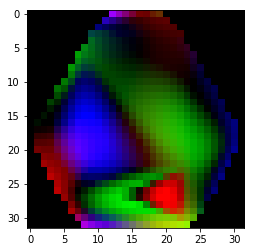

In [15]:
plt.imshow(average_map)

In [16]:
np.max(average_map), np.min(average_map)

(1.1819830761258108, -1.3349173489512975)

## Pass to d3 format (datalist)

In [7]:
freq_bands = ["theta", "beta", "alpha"]

In [8]:
def array_to_datalist(array, channel_names=freq_bands):
    datalist = []

    n_rows, n_cols, n_channels = array.shape    
    for i_row in range(n_rows):
        for j_col in range(n_cols):
            channel_data = array[i_row, j_col]
            datapoint = {"row": i_row,
                         "column": j_col
                        }
            for channel_value, channel_name in zip(channel_data, channel_names):
                datapoint[channel_name] = channel_value
                
            datalist.append(datapoint)
            
    return datalist

In [27]:
average_map_datalist = array_to_datalist(average_map)
len(average_map_datalist)

1024

In [28]:
average_map_datalist

[{'alpha': 0.0, 'beta': 0.0, 'column': 0, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 1, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 2, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 3, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 4, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 5, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 6, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 7, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 8, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 9, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 10, 'row': 0, 'theta': 0.0},
 {'alpha': 0.0, 'beta': 0.0, 'column': 11, 'row': 0, 'theta': 0.0},
 {'alpha': 1.0026588512795533,
  'beta': -0.9363870033986967,
  'column': 12,
  'row': 0,
  'theta': 0.6120782056014707},
 {'alpha': 0.7318337312002668,
  'beta': -0.7216138210620269,
  'column'

## Write avg to json

In [21]:
json_obj = {
    "rows": image_size,
    "columns": image_size,
    "bands": freq_bands,
    "averageActivity": average_map_datalist,
}

In [22]:
with open("../proyecto-insideout/data/brain-avg-activity.json", "w") as f:
    json.dump(json_obj, f)

## Get predictions from model

In [9]:
from keras.models import load_model

In [10]:
model = load_model('models/model_1.h5')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                62730     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22  

In [13]:
# predictions = np.random.normal(0.9, 1, size=y.shape)
predictions = model.predict(X)
predictions.shape

(1821, 2)

## Filter data

In [14]:
target_class = 1 # Known

In [17]:
valorations = []
for gt, pred in zip(y, predictions):
    pred_true = pred[target_class] >= 0.5
    if gt == 1 and pred_true:
        val = "TP"
    elif gt == 0 and pred_true:
        val = "FP"
    elif gt == 0 and not pred_true:
        val = "TN"
    else:
        val = "FN"
    valorations.append(val)
len(valorations)

1821

In [113]:
TP = valorations.count("TP")
FP = valorations.count("FP")
TN = valorations.count("TN")
FN = valorations.count("FN")
TP, FP, TN, FN

(820, 42, 872, 87)

In [19]:
def get_all_indexes(search_val):
    return [idx for idx, val in enumerate(valorations) if val == search_val]

In [20]:
def get_filtered_map(valoration):
    cases = X[get_all_indexes(valoration)]
    if len(cases) == 0:
        arr = np.zeros((image_size, image_size, len(freq_bands)))
    else:
        arr = cases.mean(axis=0)
    datalist = array_to_datalist(arr)
    return datalist

In [109]:
TP_map = get_filtered_map("TP")
FP_map = get_filtered_map("FP")
TN_map = get_filtered_map("TN")
FN_map = get_filtered_map("FN")

## Save locs

In [89]:
locs = np.array(locs_2d)
locs.shape

(14, 2)

In [134]:
channel_names = ['AF3',
                 'AF4',
                 'F3',
                 'F4',
                 'F7',
                 'F8',
                 'FC5',
                 'FC6',
                 'T7',
                 'T8',
                 'T3',
                 'T4',
                 'O1',
                 'O2',
                ]

In [179]:
def get_locs_as_datalist(locs, n_gridpoints=image_size):
    arr_x = locs[:, 0]
    arr_y = locs[:, 1]
    min_x, max_x = min(arr_x), max(arr_x)
    min_y, max_y = min(arr_y), max(arr_y)
    grid_x, grid_y = np.mgrid[
                         min_x:max_x:n_gridpoints*1j,
                         min_y:max_y:n_gridpoints*1j
                     ]
    x_values = grid_x[:,0]
    y_values = grid_y[0]
    
    datalist = []
    for idx, loc in enumerate(locs):
        x, y = loc
        column = np.argmin(np.abs(x_values - x))
        row = np.argmin(np.abs(y_values - y))
        # print(type(row), type(column))
        
        datalist.append({
            "row": int(row),
            "column": int(column),
            "name": channel_names[idx],
        })
        
    
    return datalist

In [180]:
locs_datalist = get_locs_as_datalist(locs)
locs_datalist

[{'column': 7, 'name': 'AF3', 'row': 27},
 {'column': 20, 'name': 'AF4', 'row': 27},
 {'column': 10, 'name': 'F3', 'row': 23},
 {'column': 17, 'name': 'F4', 'row': 23},
 {'column': 3, 'name': 'F7', 'row': 23},
 {'column': 24, 'name': 'F8', 'row': 23},
 {'column': 7, 'name': 'FC5', 'row': 19},
 {'column': 20, 'name': 'FC6', 'row': 19},
 {'column': 7, 'name': 'T7', 'row': 4},
 {'column': 20, 'name': 'T8', 'row': 4},
 {'column': 0, 'name': 'T3', 'row': 15},
 {'column': 27, 'name': 'T4', 'row': 15},
 {'column': 10, 'name': 'O1', 'row': 0},
 {'column': 17, 'name': 'O2', 'row': 0}]

## Write filtered data to json

In [181]:
json_obj = {
    "rows": image_size,
    "columns": image_size,
    "bands": freq_bands,
    "channels": locs_datalist,
    "confusion": [TP, FP, TN, FN],
    "truePositiveMap": TP_map,
    "falsePositiveMap": FP_map,
    "trueNegativeMap": TN_map,
    "falseNegativeMap": FN_map,
    "classes": ["Known", "Unknown"],
}

In [182]:
with open("../proyecto-insideout/data/brain-activity.json", "w") as f:
    json.dump(json_obj, f, indent=4)

## Test images side

In [173]:
dummy_x = np.zeros((1, 14*2))
dummy_x[0, :2] = 1 # First two channels are in the forehead (AF3 and AF4)
dummy_x

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [171]:
dummy_images = gen_images(np.array(locs_2d), dummy_x, 32).transpose((0, 1, 3, 2))
dummy_images.shape

(1, 2, 32, 32)

(32, 32)

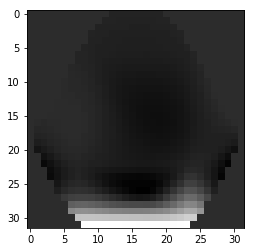

In [174]:
# Forehead is on the bottom of the page, in this case
img = dummy_images[0, 0, :, :]
plt.imshow(img, cmap='gray')
img.shape

## Analyze images

In [37]:
tp_cases = X[get_all_indexes("TP")].mean(axis=0)
fp_cases = X[get_all_indexes("FP")].mean(axis=0)
tn_cases = X[get_all_indexes("TN")].mean(axis=0)
fn_cases = X[get_all_indexes("FN")].mean(axis=0)
# sub = tp_cases - tn_cases
# sub.shape
# datalist = array_to_datalist(cases.mean(axis=0))

In [43]:
tp_cases.shape

(28, 28, 3)

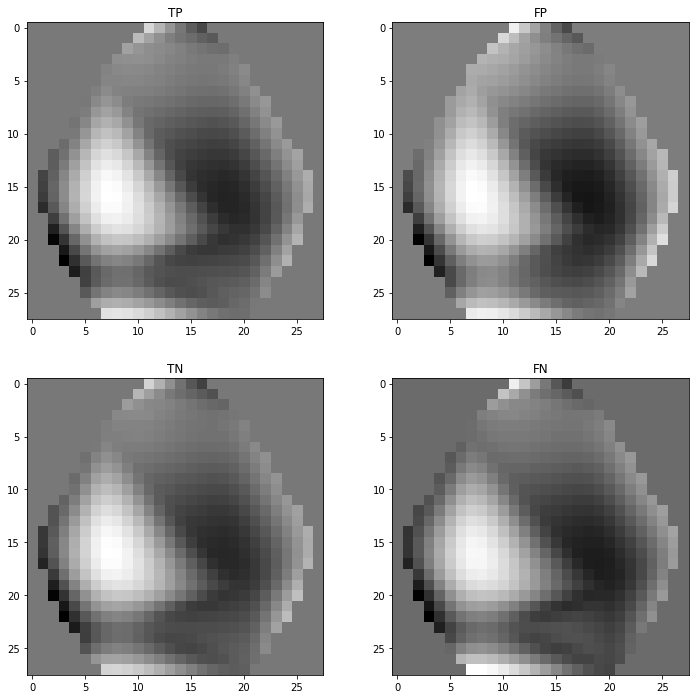

In [47]:
imshow = lambda arr: plt.imshow(arr[:,:,2], cmap='gray')

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title("TP")
imshow(tp_cases)

plt.subplot(2, 2, 2)
plt.title("FP")
imshow(fp_cases)

plt.subplot(2, 2, 3)
plt.title("TN")
imshow(tn_cases)

plt.subplot(2, 2, 4)
plt.title("FN")
imshow(fn_cases)

In [51]:
from math import ceil

In [63]:
X.std(axis=(0,1,2))

array([0.82375447, 0.82375447, 0.82375447])

In [81]:
X.shape[0]/16

113.8125

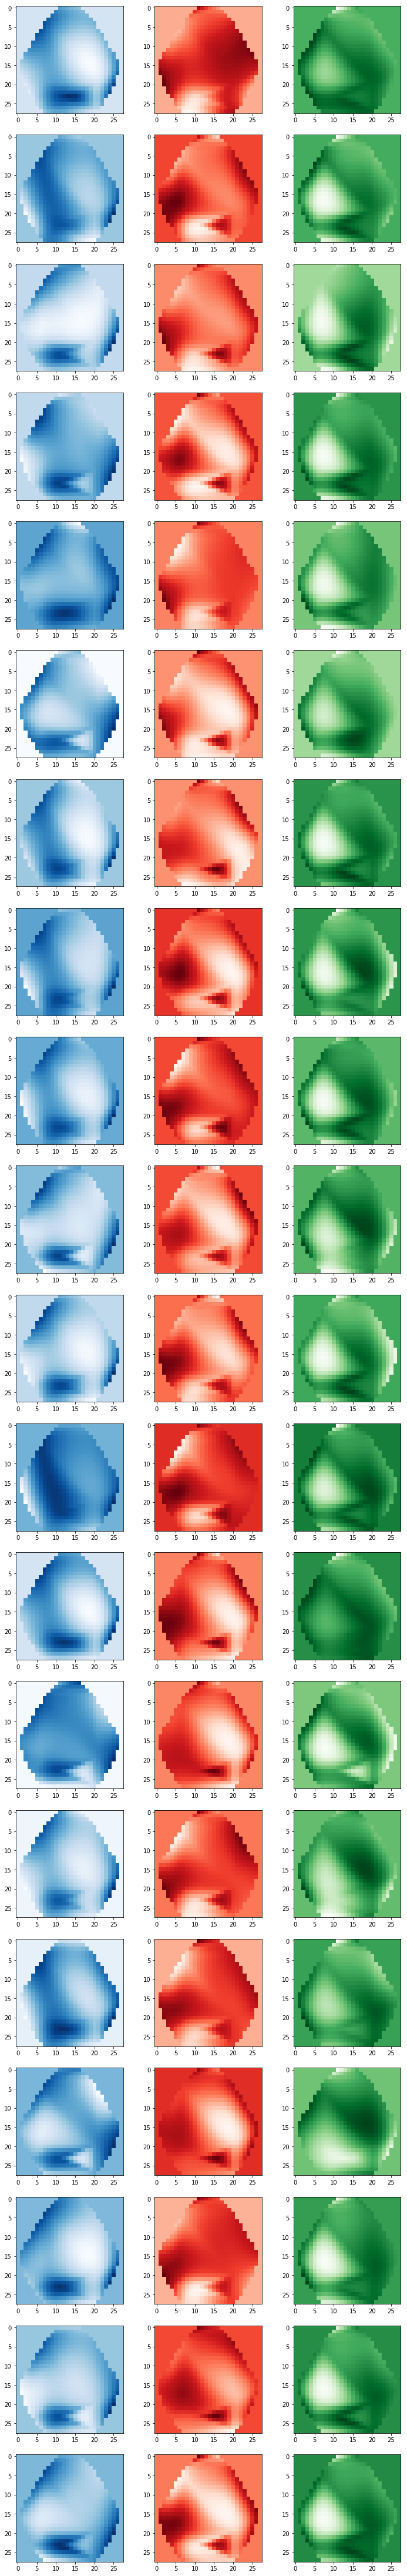

In [84]:
cmaps = ['Blues', 'Reds', 'Greens']
imshow = lambda arr, j: plt.imshow(arr, cmap=cmaps[j])

n = 20
n_cols = 3
n_rows = ceil(n * 3 / n_cols)
n_shifted = 120

subplot_idx = 1
plt.figure(figsize=(12, n*4))
for idx, arr in enumerate(X[n_shifted:n_shifted+n]):
    for band_j in range(3):
        plt.subplot(n_rows, n_cols, subplot_idx)
        imshow(1-arr[:,:,band_j], band_j)
        subplot_idx += 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


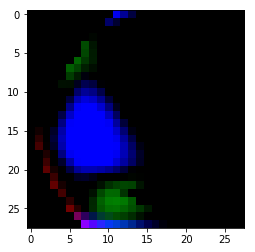

In [29]:
plt.imshow(X[16])

In [85]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9],
              [10,11,12],
             ])
a.shape

(4, 3)